In [96]:
import json
import os

from collections import defaultdict

import numpy as np
import pandas as pd


from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [97]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
import pickle

In [16]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize 
# from nltk.corpus import stopwords
# import nltk
# import re

In [17]:
data = pd.read_csv('data.csv')
data.shape

(48410, 6)

In [18]:
data.columns

Index(['paper_id', 'title', 'authors', 'abstract', 'body_text',
       'body_text_new'],
      dtype='object')

In [19]:
data.head(5)

,paper_id,title,authors,abstract,body_text,body_text_new
0,f6b29be971089bfe0916c64ab9fbddcec38a7436,Faecal immunochemical testing (FIT): Sources o...,"Tim James, Brian D Nicholson, Rhiannon Marr, M...",Abstract\n\nAims: To determine analytical capa...,Introduction\n\nColorectal cancer is globally ...,"introduction, colorectal, cancer, globally, th..."
1,005d189d5bd7ac01aee65e934fd3d5186a3f7b27,Relationship between Average Daily Temperature...,"Behzad Pirouz, Amirsina Golmohammadi, Hasti Sa...",Abstract\n\nThe rapid outbreak of the new Coro...,Introduction\n\nThe outbreak of infectious dis...,"introduction, outbreak, infectious, disease, a..."
2,f905f78b32f63c6d14a79984dfb33f1b358b8ab4,Multimerization of HIV-1 integrase hinges on c...,"Meytal Galilee, Akram Alian",Abstract\n\nNew anti-AIDS treatments must be c...,"\n\nIn the absence of a curative treatment, th...","absence, curative, treatment, highly, active, ..."
3,607e0074d8ff40c272b958c2fe48793fedfc785e,Virus shedding patterns in nasopharyngeal and ...,"Ning Zhang, Yuhuan Gong, Fanping Meng, Yuhai B...",NaN,"\n\nthe author/funder, who has granted medRxiv...","author/funder, granted, medrxiv, license, disp..."
4,72e25b728c6c62fb3a4e2c59c8ee48de4b5ee452,Phylogenetic Analysis of the Novel Coronavirus...,"Aditi Joshi, Sushmita Paul",Abstract\n\nRecently classified as a pandemic ...,\n\nThe pandemic of COVID-19 is taking a troll...,"pandemic, covid-19, taking, troll, health, fin..."


In [20]:
data.describe()

,paper_id,title,authors,abstract,body_text,body_text_new
count,48410,43061,43391,34687,48410,48396
unique,48409,41311,40936,33927,47839,47780
top,5d0d0bd116976e1412c10a84902894999df4a342,Comment,"Xxx Xxx Xxx • Volume, Xxx Number",Abstract\n\nThe purpose of this form is to pro...,"Dear Editor,\n\nIn previous reports, workers h...",-p
freq,2,60,28,29,4,5


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48410 entries, 0 to 48409
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   paper_id       48410 non-null  object
 1   title          43061 non-null  object
 2   authors        43391 non-null  object
 3   abstract       34687 non-null  object
 4   body_text      48410 non-null  object
 5   body_text_new  48396 non-null  object
dtypes: object(6)
memory usage: 2.2+ MB


In [22]:
#Body text data that might be useful
data['body_word_count'] = data['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
data['body_unique_words']= data['body_text'].apply(lambda x:len(set(str(x).split()))) 

In [23]:
data.drop_duplicates(['abstract', 'body_text'], inplace=True)
data['abstract'].describe(include='all')
data.dropna(inplace=True)

In [24]:
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(data))):
    # split by space into list, take the first x intex, join with space
    text = data.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 32570/32570 [03:05<00:00, 175.85it/s]


In [25]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
data['language'] = languages
for key,value in languages_dict.items():
    print(str(key) +' : ' + str(value))

ca : 1
et : 1
fr : 189
nl : 48
ru : 1
en : 32146
it : 10
cy : 2
pt : 10
id : 1
ko : 1
da : 1
de : 34
es : 122
pl : 3


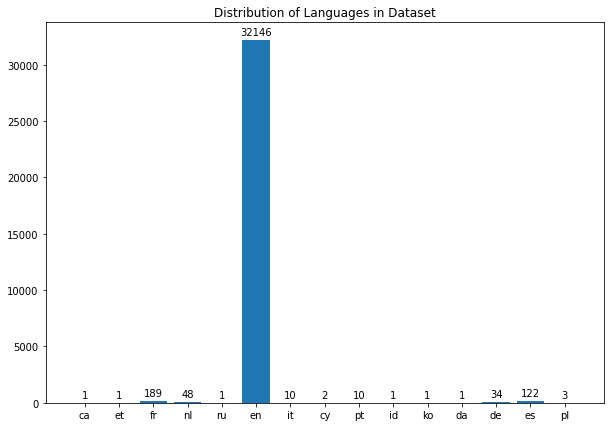

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
fig.size = (40,20)
graph = ax.bar(range(len(languages_dict)), list(languages_dict.values()))
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
#plt.pie(list(languages_dict.values()), labels=list(languages_dict.keys()))
ax.set_title("Distribution of Languages in Dataset")
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(graph)
plt.show()

In [27]:
#let's drop all non-english languages!
data = data[data['language'] == 'en']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32146 entries, 0 to 48409
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   paper_id           32146 non-null  object
 1   title              32146 non-null  object
 2   authors            32146 non-null  object
 3   abstract           32146 non-null  object
 4   body_text          32146 non-null  object
 5   body_text_new      32146 non-null  object
 6   body_word_count    32146 non-null  int64 
 7   body_unique_words  32146 non-null  int64 
 8   language           32146 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxfeatures):
    
    vectorizer = TfidfVectorizer(max_df=0.1,
                                 min_df = 0.05,
                                 ngram_range = (1,2),
                                 max_features=maxfeatures)
    X = vectorizer.fit_transform(text)
    return X


In [ ]:
text = data['body_text_new'].values
X = vectorize(text, 2 ** 10)
X.shape

In [ ]:
#We obviously want to reduce our dimensionality
#We will do this using PCA to hopefully make kmeans clustering a little easier
#We'll try to keep a 90% variance

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

In [ ]:
#So before we run kmeans we need to find what k we should use
#We'll compute the distortion value (distance from center of cluster)

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(4, 40)
for k in K:
    k_means = KMeans(n_clusters=k).fit(X_reduced)
    distortions.append(k_means.inertia_)

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'r')
plt.plot(X_line, Y_line, 'b')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
#So it looks like a good k is 19! 
#Let's run kmeans with 19
k = 19
kmeans = KMeans(n_clusters=k)
y_predictions = kmeans.fit_predict(X_reduced)
data['y_predictions'] = y_predictions
print('Done')

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X.toarray())

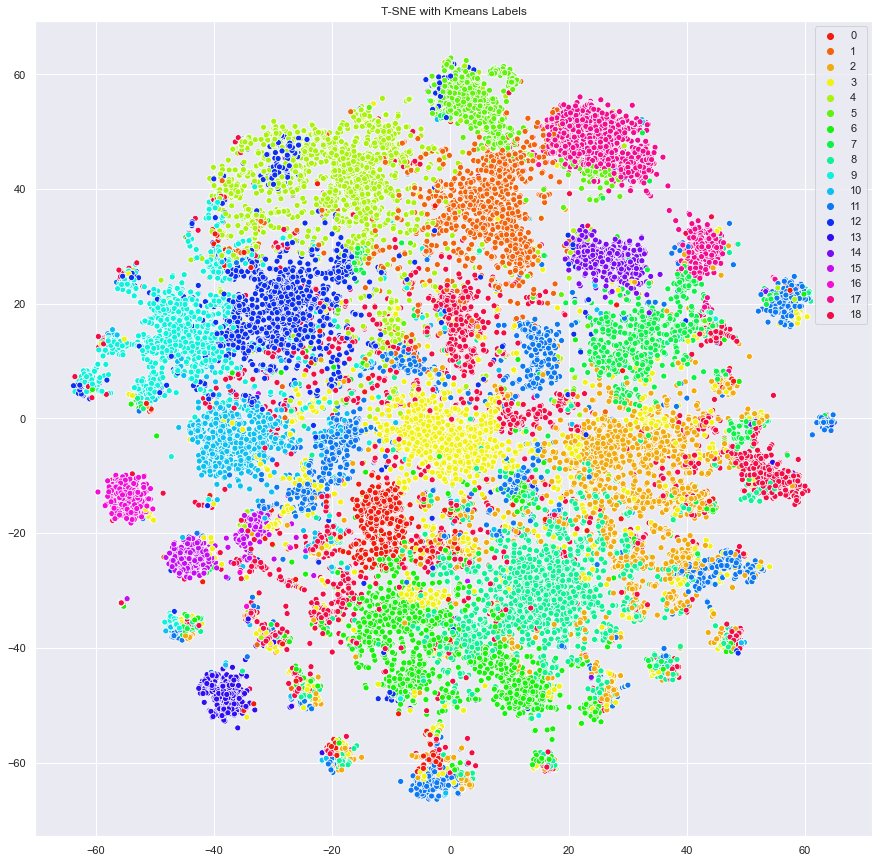

In [100]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(19, l=.5, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_predictions, legend='full', palette=palette)
plt.title('T-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizers = []
    
for i in range(0, 19):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9,
                                       stop_words='english',
                                       lowercase=True,
                                       token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorized_data = []

for cluster,vectorizer in enumerate(vectorizers):
    vectorized_data.append(vectorizer.fit_transform(data.loc[data['y_predictions'] == cluster, 'body_text_new']))

In [ ]:
num_topics = 10

lda_models = []
for ii in range(0, 19):
    lda = LatentDirichletAllocation(n_components=num_topics,
                                    learning_method='online',
                                    verbose=False)
    lda_models.append(lda)

In [ ]:
clusters_lda_data = []

for cluster, lda in enumerate(lda_models):    
    clusters_lda_data.append((lda.fit_transform(vectorized_data[cluster])))

In [ ]:
def print_topics(model, count_vectorizer, n_top_words=10):
    top_topics = []
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        topic = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        top_topics.append(topic)
        print(topic)
        
    return top_topics

In [ ]:
def selected_topics(model, vectorizer, n_top_words=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i],
                  topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [ ]:
len(all_keywords)


In [ ]:
#Let's write these words to a file
with open('topics.txt','w') as fout:
    for topic_num, words in enumerate(all_keywords):
        fout.write('Topic ' + str(topic_num) + ':\n' + ', '.join(words) + '\n\n')

In [ ]:
#Let's save all the files that took forever to run
data.to_csv('data1.csv',index=False)

pickle.dump(y_predictions, open("y_predictions.p", "wb" ))

In [ ]:
data = pd.read_csv('data1.csv')
data.head(5)

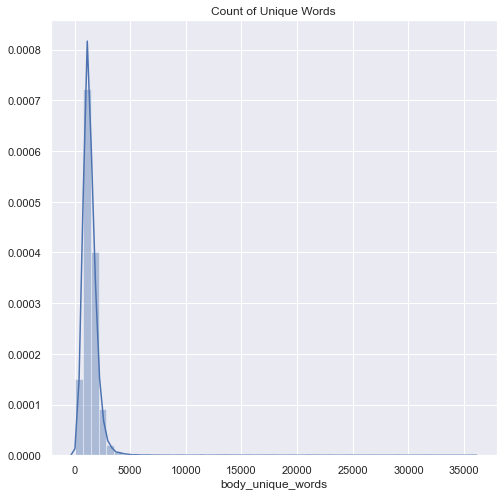

In [98]:
sns.set(rc={'figure.figsize':(8,8)})
sns.distplot(data['body_unique_words'])
plt.title("Count of Unique Words")
plt.savefig("unique_words.png")

In [ ]:
# USEmodel = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# train = USEmodel(data.body_text)
# train_m = tf.train.Checkpoint(v=tf.Variable(train))

# train_m.f = tf.function( lambda  x: exported_m.v * x, input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])

# model = train_m.v.numpy()

# pickle.dump(model, open('full_tfidf_model.pk', 'wb'))

In [ ]:
# count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
# count_data = count_vectorizer.fit_transform(data['body_text_new'])

In [ ]:
# lda = pickle.load(open('initial_lda_model.pk', 'rb'))
# doc_topic = lda.transform(count_data)

In [ ]:
# def print_topics(model, count_vectorizer, n_top_words):
#     top_topics = []
#     words = count_vectorizer.get_feature_names()
#     for topic_idx, topic in enumerate(model.components_):
#         print("\nTopic #%d:" % topic_idx)
#         topic = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
#         top_topics.append(topic)
#         print(topic)
        
#     return top_topics



In [ ]:
# risk = data[data['topic']==0]
# risk.shape

In [ ]:
# def SearchDocument(query,size=100):
#     q =[query]
#     Q_Train = USEmodel(q)
    
#     linear_similarities = linear_kernel(Q_Train, model).flatten() 
    
#     Top_index_doc = linear_similarities.argsort()[:-(size+1):-1]
#     #print(Top_index_doc)
#     linear_similarities.sort()
#     find = pd.DataFrame()
#     for i,index in enumerate(Top_index_doc):
#         find.loc[i,'index'] = str(index)
#         find.loc[i,'Paper_ID'] = data['paper_id'][index] 
#         find.loc[i,'Title'] = data['title'][index] 
#         find.loc[i,'abstract'] = data['abstract'][index]
#     for j,simScore in enumerate(linear_similarities[:-(size+1):-1]):
#         find.loc[j,'Score'] = simScore
        
#     if size==1:
#         if find.isnull().values.any():
#             print("Query: ",query,".  Title of the Research Paper is missing, Paper ID is:",find.loc[0,'Paper_ID'],"\n")
#         else:
#             print("Query: ",query,".  Title of the Research Paper:",find.loc[0,'Title'],"\n")
#     else:
#         return find

In [ ]:
def body(df):
    index = df['index'][0]
    return custom['abstract'][int(index)]

In [99]:
for x in vectorized_data:
    freq = dict()
    for word, idx in x.vocabulary_.items():
        freqs[word] = x.getcol(idx).sum()
    w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000).fit_words(freqs)
    plt.figure(figsize=(20,10))
    plt.imshow(w)
    plt.show()

AttributeError: vocabulary_ not found

In [ ]:
# v = TfidfVectorizer(max_df=0.1, min_df = 0.05,max_features = 10000,tokenizer = tokenize,ngram_range = (1,2))
# x = v.fit_transform(risk['abstract'])
# freqs = dict()
# for word, idx in v.vocabulary_.items():
#     freqs[word] = x.getcol(idx).sum()
# w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000).fit_words(freqs)
# plt.figure(figsize=(20,10))
# plt.imshow(w)
# plt.show()

In [ ]:
#meta=pd.read_csv(current + '/CORD-19-research-challenge/metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
#print (meta.shape)

In [ ]:
#meta.describe()

Hmm so it looks like there are duplicate titles AND abstracts, possible just a data collection error. Let's drop the articles that have the exact same abstract, since it's possible to have the same title and be completely different articles. We'll also drop missing abstracts.

In [ ]:
#meta = meta.drop_duplicates(subset='abstract', keep="first")
#meta = meta.dropna(subset=['abstract'])
#meta.describe()


Let's search the abstracts for words that are relevant to risk factors.

Task 1 -> Obviously we want to tokenize our words in the abstract and kick out gross stop words (tfidf)
Task 2 -> Perform some stemming or lemmitization on the abstract to have important words that we're looking for
Task 3 -> Only accept the lemmitized/stemmed abstracts that contain cov2, covid etc.. we need a better list


We would like a more complete list of what we could specifically be looking for, but for now we're going to look at just a few words.

In [ ]:
#v = TfidfVectorizer(max_df=0.80, min_df = 0.05,max_features = 10000,tokenizer = tokenize_and_stem,ngram_range = (1,2))
#x = v.fit_transform(meta['abstract'])
#w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000).fit_words(v.vocabulary_)
#plt.imshow(w)
#plt.show()